# Preprocessing and Data Exploration
In this notebook, we will be exploring the `Twitter Dataset: Twitter` from Kaggle.
<br> This dataset contains `10,000` recent tweets regarding #Tesla or #tesla up to `July 12th, 2022`. The dataset contains much information including `user ID`, `hashtags` used in the Tweets, and `other important features`.

<br> For our purposes with this project, however, we will be looking at a `single descriptive feature`: the `tweets`.
<br> Our `goal` is simple: we would like to learn the `general sentiment` of Twitter users towards `Tesla`. 

<br> For the entirety of this semester thus far, we have been working with a particular type of dataset. 
The datasets we have been working with typically include a variety of descriptive features that may or may not have a bearing on the target feature. 
<br> In our project’s case, our only descriptive feature is the tweets. The `target feature` will be the `sentiment score` for each of the tweets.
## Import Packages
To begin our exploration of this dataset, we import several packages that we will be using throughout the exploration process. 

In [1]:
import numpy as np 
import pandas as pd 
import re
import matplotlib.pyplot as plt
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud
import warnings
warnings.filterwarnings("ignore")
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Jordan\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

## Read In and Clean Data
We will now `read in` the original Tesla tweet dataset from Kaggle. You can find the raw dataset on our github page [here](https://raw.githubusercontent.com/JordanVencel/DFProject/main/Tesla.csv).
<br> We store the data in a pandas dataframe because of the variety of utility functions pandas provides. There are a few steps to this initial data cleansing:

1. `Remove` `non-english tweets` (tweets that are not in the english language) first.
2. `Copy` the tweet (`text`) `data` to a new dataframe. 
3. `Remove` hashtags, non-english symbols, hyperlinks, and other `irrelevant information` from the tweets.

This last point is the most important one. Removing irrelevant text data is essential to the proper use of the sentiment analysis model. 

In [2]:
# Read in original csv from my GitHub
initDataDf = pd.read_csv("https://raw.githubusercontent.com/JordanVencel/DFProject/main/Tesla.csv")
# Filter out tweets that are not in english 
filterDf = initDataDf[['language','tweet']]
filterDf = filterDf.where(filterDf['language'] == 'en')
filterDf = filterDf[filterDf['language'].notna()]
# Grab only tweet text data
tweetDf = filterDf['tweet'].to_frame()
tweetDf = tweetDf.reset_index(drop=True)
# Filter out @s, hashtags, external links, and other irrelavant information using regex
for row in tweetDf.iterrows():
    index = row[0]
    booty = re.sub(r"([@#])\w+", "", row[1][0])
    booty = re.sub(r"(https)([^\s]+)", "", booty)
    booty = re.sub(r"(\?)", "", booty)
    booty = re.sub(r"(.com)", "", booty)
    booty = re.sub(r"([^A-Za-z'\"\s])", "", booty)
    booty = re.sub(r"(^[ \t]+)", "", booty)
    booty = booty.lower()
    tweetDf.iloc[index][0] = booty

tweetDf

,tweet
0,i have six of them still live at home being h...
1,then go for your dozen kids you are just missi...
2,about buying a country you could turn it in...
3,actual receipts and yet you havent asked anyon...
4,tesla wall battery for the save power went out...
...,...
7353,elon musk liked a tweet from whole mars catalo...
7354,dude only said he is buying twitter to sell b...
7355,give me your tesla
7356,chick fil a should definitely go public they s...


## Prepare Dataframe for Use With VADER Sentiment Analysis Model
We can now begin to prepare our data for use with the `VADER` model. This essentially consists of adding an additional column to our working dataframe with a "row_id" record.

`VADER` (Valence Aware Dictionary for Sentiment Reasoning) is a model used for `text sentiment analysis` that is `sensitive` to both polarity (`positive/negative`) and intensity (`strength`) of emotion. It is available in the `NLTK` package and can be applied directly to `unlabeled text data`.
<br> `VADER` sentiment analysis relies on a `dictionary` that maps `lexical features` to `emotion intensities` known as sentiment scores. The sentiment score of a text can be obtained by summing up the intensity of each word in the text.
<br> `VADER` is intelligent enough to understand the `basic context` of these words, such as “did not love” as a negative statement. It also `understands` the emphasis of `capitalization` and `punctuation`.

In [3]:
# Set up row id formatting for nltk
import sys
tweetDf['row_id'] = 0
tweetDf = tweetDf[['row_id', 'tweet']]
for row in tweetDf.iterrows():
    index = row[0]
    newVal = int(index) + 1
    tweetDf['row_id'][index] = newVal

## Run Tweets Through VADER Model
Next, we calculate the `polarity scores` for each tweet in our working dataframe by running the tweets through the VADER model.
Then we can drop any null values, invalid values, and duplicates.

In [4]:
sentimentDf = pd.DataFrame()
sentimentDf['row_id'] = ['99999999999']
sentimentDf['sentiment_type'] = 'NA999NA'
sentimentDf['sentiment_score'] = 0

print('Processing sentiment scores, please wait...')
sia = SentimentIntensityAnalyzer()
tempDf = sentimentDf
for index, row in tweetDf.iterrows():
    scores = sia.polarity_scores(row[1])
    for key, value in scores.items():
        temp = [key,value,row[0]]
        sentimentDf['row_id'] = row[0]
        sentimentDf['sentiment_type'] = key
        sentimentDf['sentiment_score'] = value
        tempDf = tempDf.append(sentimentDf)

#remove dummy row with row_id = 99999999999
tempDf_cleaned = tempDf[tempDf.row_id != '99999999999']
#remove duplicates if any exist
tempDf_cleaned = tempDf_cleaned.drop_duplicates()
# only keep rows where sentiment_type = compound
tempDf_cleaned = tempDf[tempDf.sentiment_type == 'compound']

tempDf_cleaned['tweet'] = tweetDf['tweet']

print("Sentiment scores done!")
sentimentDf['row_id'] = ['99999999999']
sentimentDf['sentiment_type'] = 'NA999NA'
sentimentDf['sentiment_score'] = 0

print('Processing sentiment analysis...')
sia = SentimentIntensityAnalyzer()
tempDf = sentimentDf
for index, row in tweetDf.iterrows():
    scores = sia.polarity_scores(row[1])
    for key, value in scores.items():
        temp = [key,value,row[0]]
        sentimentDf['row_id'] = row[0]
        sentimentDf['sentiment_type'] = key
        sentimentDf['sentiment_score'] = value
        tempDf = tempDf.append(sentimentDf)
#remove dummy row with row_id = 99999999999
tempDf_cleaned = tempDf[tempDf.row_id != '99999999999']
#remove duplicates if any exist
tempDf_cleaned = tempDf_cleaned.drop_duplicates()
# only keep rows where sentiment_type = compound
tempDf_cleaned = tempDf[tempDf.sentiment_type == 'compound']

    
display(tempDf_cleaned)

Processing sentiment scores, please wait...
Sentiment scores done!
Processing sentiment analysis...


,row_id,sentiment_type,sentiment_score
0,1,compound,-0.4767
0,2,compound,-0.2960
0,3,compound,0.5267
0,4,compound,0.4404
0,5,compound,0.2732
...,...,...,...
0,7354,compound,0.4215
0,7355,compound,-0.0516
0,7356,compound,0.0000
0,7357,compound,0.6908


We `reset` the pandas dataframe `indexes`. 

In [5]:
tempDf_cleaned = tempDf_cleaned.reset_index(drop=True)
tempDf_cleaned

,row_id,sentiment_type,sentiment_score
0,1,compound,-0.4767
1,2,compound,-0.2960
2,3,compound,0.5267
3,4,compound,0.4404
4,5,compound,0.2732
...,...,...,...
7353,7354,compound,0.4215
7354,7355,compound,-0.0516
7355,7356,compound,0.0000
7356,7357,compound,0.6908


## Recombine Cleansed Data
We have now fully cleansed the data. 
<br> We `recombine` the tweet data and sentiment scores into a master dataframe that is `ready for evaluation` using proven classifiers. 

In [6]:
recombined_df = pd.DataFrame(columns=['row_id', 'tweet', 'sentiment_type', 'sentiment_score'])
recombined_df['tweet'] = tweetDf['tweet']
recombined_df[['row_id', 'sentiment_type', 'sentiment_score']] = tempDf_cleaned[['row_id', 'sentiment_type', 'sentiment_score']]
recombined_df

,row_id,tweet,sentiment_type,sentiment_score
0,1,i have six of them still live at home being h...,compound,-0.4767
1,2,then go for your dozen kids you are just missi...,compound,-0.2960
2,3,about buying a country you could turn it in...,compound,0.5267
3,4,actual receipts and yet you havent asked anyon...,compound,0.4404
4,5,tesla wall battery for the save power went out...,compound,0.2732
...,...,...,...,...
7353,7354,elon musk liked a tweet from whole mars catalo...,compound,0.4215
7354,7355,dude only said he is buying twitter to sell b...,compound,-0.0516
7355,7356,give me your tesla,compound,0.0000
7356,7357,chick fil a should definitely go public they s...,compound,0.6908


## Pre-Evaluation Visualizations
We will now perform some `preliminary visualizations` in order to gain an even `better understanding` of the data we are working with. 
<br> We first import the necessary packages. 

In [7]:
import pandas as pd 
import numpy as np 
import re 

from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer

import seaborn as sns
from matplotlib import  pyplot as plt 
from matplotlib.pyplot import figure
import plotly.graph_objects as go 

from gensim.models import Word2Vec, FastText

## Vectorize Tweet Data
Word Embeddings or `Word vectorization` is a methodology in NLP to map words or phrases from `vocabulary` to a corresponding `vector` of real numbers which used to find word predictions, word similarities/semantics. The process of converting words into numbers are called `Vectorization`.

We will perform `word vectorization` on our dataset in order to visually represent different relationships in our data. 

In [8]:
tfidf_vectorizer = TfidfVectorizer(max_df = 0.90, min_df = 2, max_features = 1000, stop_words = 'english')
tfidf = tfidf_vectorizer.fit_transform(recombined_df['tweet'])

tokenized_tweet = recombined_df['tweet'].apply(lambda x: x.split())
w2v = Word2Vec(tokenized_tweet, min_count = 5, vector_size = 200, window = 5, sg = 1, hs = 0, workers = 32, seed = 34, negative = 10)
w2v.train(tokenized_tweet, total_examples=len(recombined_df['tweet']), epochs=20)

(2060108, 3116360)

## Similarity Graph

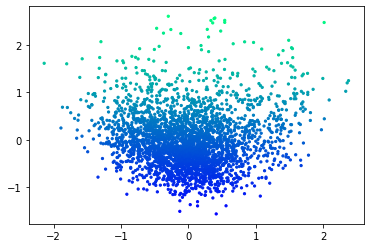

<Figure size 12800x9600 with 0 Axes>

In [9]:
X = w2v.wv[w2v.wv.key_to_index]
pca = PCA(n_components = 2)
result = pca.fit_transform(X)

x = result[:, 0]
y = result[:, 1]
plt.scatter(x, y, c = y, s = 5, cmap = 'winter')

words = list(w2v.wv.key_to_index)

figure(figsize=(16, 12), dpi=800)
plt.show()

## Dilineate Useful and Non-Useful Text Data

In [10]:
words = w2v.wv.index_to_key
clean_words = []
usless_words = []
for word in words:
    if (len(word) > 3):
        clean_words.append(word)
    else:
        usless_words.append(word)

word_dict = {}
total_words = 0
total_usefull = 0
total_useless = 0
useless_dict = {}
total_dict = {}
for tweets in tokenized_tweet:
    for x in tweets:
        total_words += 1

        if (x in clean_words):
            total_usefull += 1
        if (x in usless_words):
            total_useless +=1

        if ((x in useless_dict) and (x in usless_words)):
            useless_dict[x] += 1
        elif ((x not in useless_dict) and (x in usless_words)):
            useless_dict[x] = 1

        if (x in word_dict and x in clean_words):
            word_dict[x] += 1
        elif (x not in word_dict and x in clean_words):
            word_dict[x] = 1


# Top 10 MOST Common Useful Words
In this context, `useful` words are words that are `longer than three` letters. 

<AxesSubplot:>

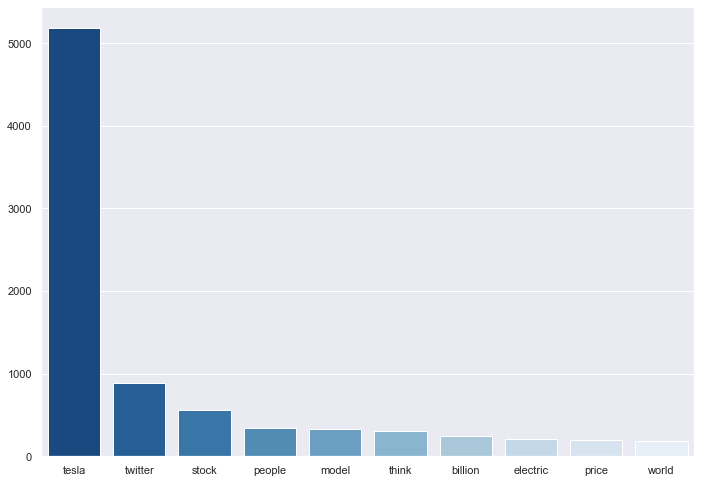

In [11]:
data = {'words': ['tesla', 'twitter', 'stock', 'people', 'model', 'think', 'billion', 'electric', 'price', 'world'],
        'freq': [5181,891,557,337,336,302,244,211,194,191]}
usefull_df = pd.DataFrame(data=data)

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.barplot(data=data, x="words", y="freq", palette= "Blues_r")

# Top 10 LEAST Useful Words
In this context, `least useful` words are words that are `three characters or less`. 

<AxesSubplot:>

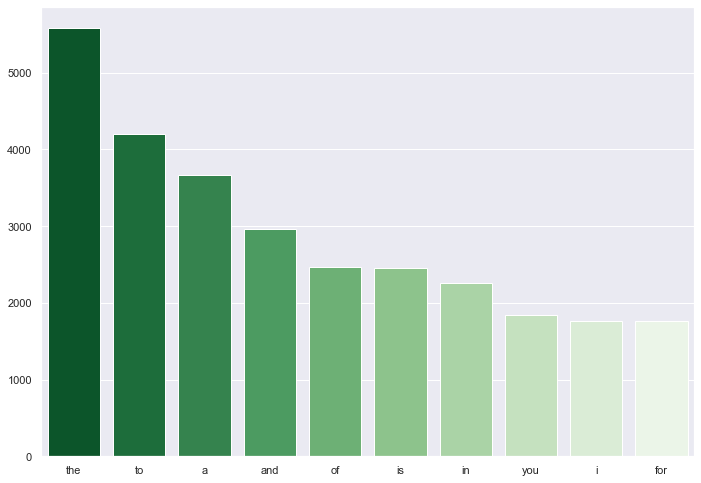

In [12]:
data = {'words': ['the', 'to', 'a', 'and', 'of', 'is', 'in', 'you', 'i', 'for'],
        'freq': [5582, 4206, 3673, 2966, 2462, 2449, 2264, 1846, 1763, 1762]}
useless_df = pd.DataFrame(data=data)

sns.barplot(data=data, x="words", y="freq", palette="Greens_r")

# Word Clouds for Positive, Neutral, and Negative Words

In [19]:
def categorise(row):
      if row['sentiment_score'] > .05:
        return 'Positive'
      elif row['sentiment_score'] < -.05:
        return 'Negative'
      else:
        return 'Neutral'

def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)

df = pd.read_csv("https://raw.githubusercontent.com/JordanVencel/DFProject/main/Processed_Data.csv")
df['sentiment'] = df.apply(lambda row: categorise(row), axis=1)
df['tweet'] = df['tweet'].apply(lambda x: cleaning_numbers(x))

## Negative Word Wordcloud

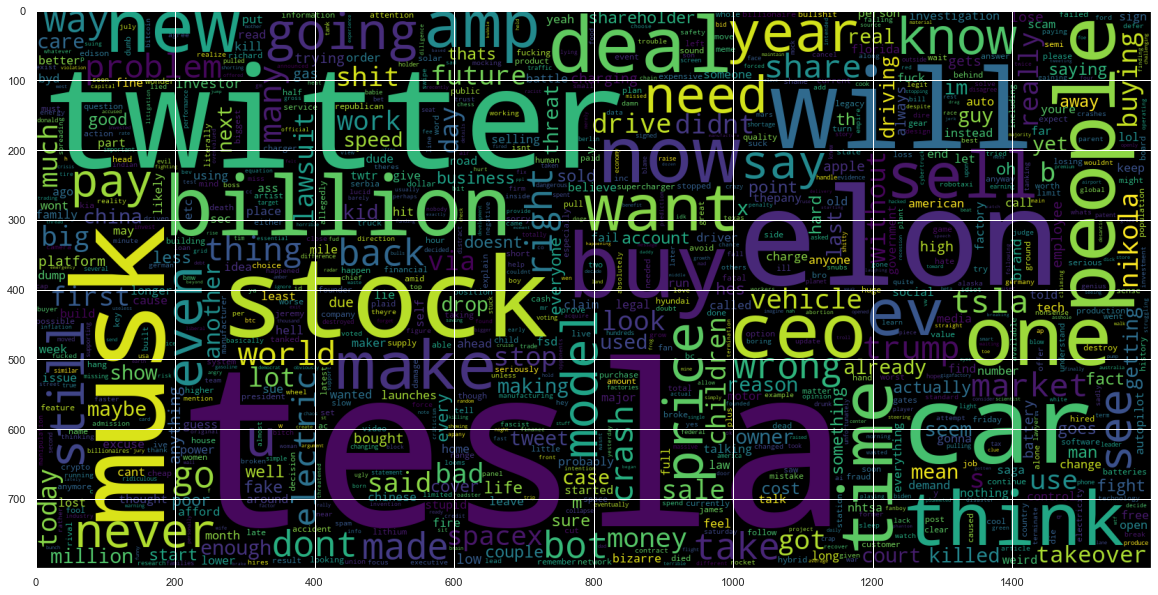

In [21]:
neg_df = df.loc[df['sentiment'] == 'Negative'] 

plt.figure(figsize=(20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(neg_df['tweet']))
plt.imshow(wc)

## Neutral Word Wordcloud

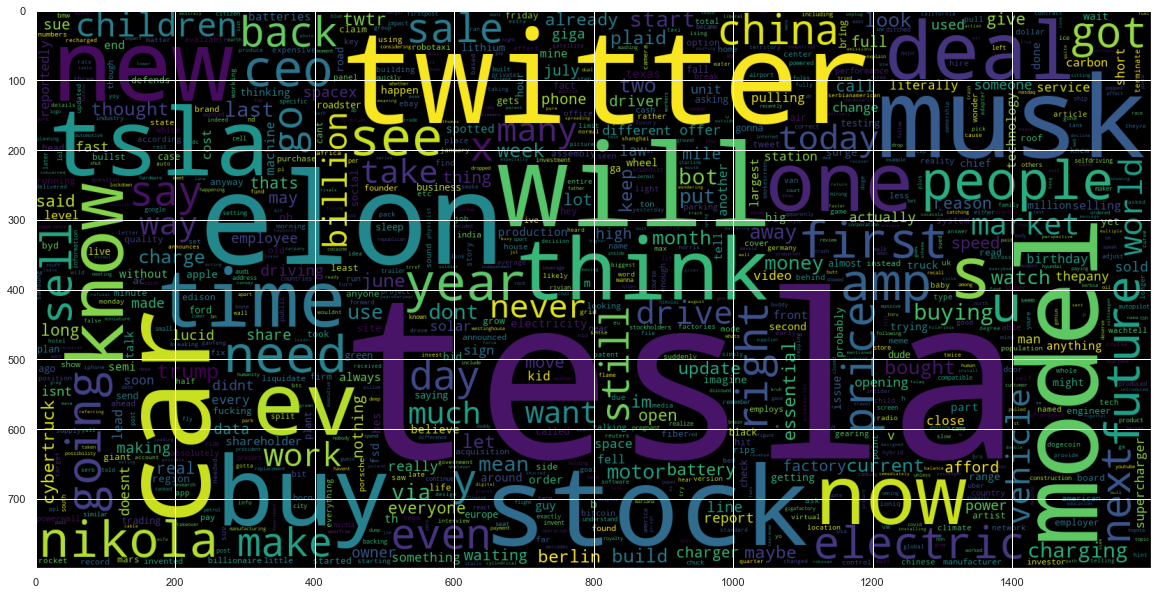

In [20]:
neutral_df = df.loc[df['sentiment'] == 'Neutral'] 

plt.figure(figsize=(20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(neutral_df['tweet']))
plt.imshow(wc)

## Positive Word Wordcloud

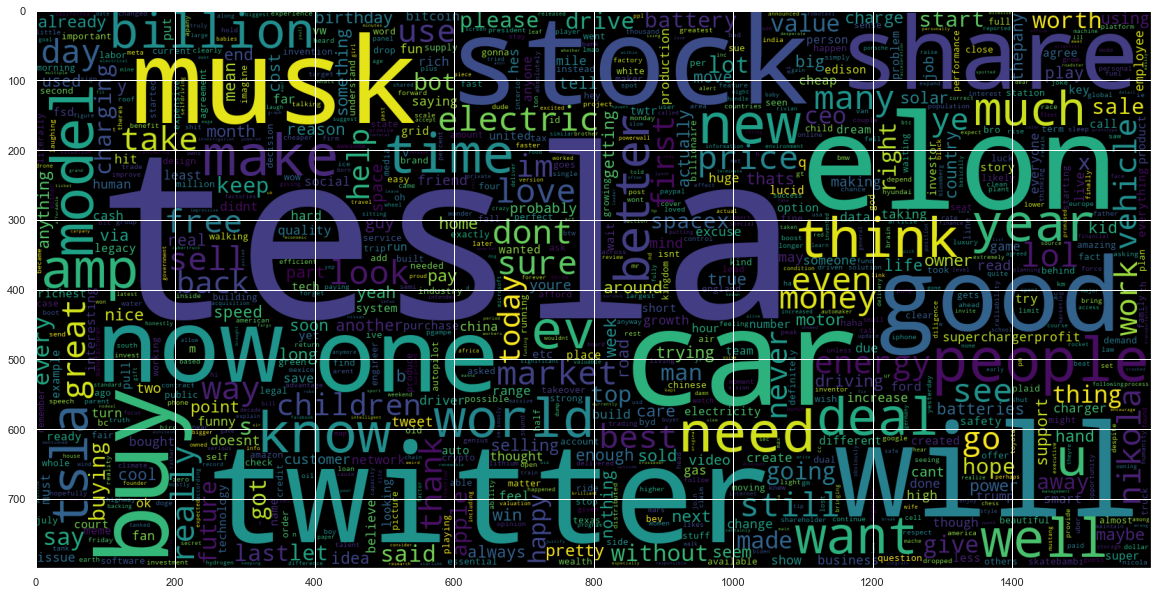

In [22]:
pos_df = df.loc[df['sentiment'] == 'Positive'] 

plt.figure(figsize=(20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(pos_df['tweet']))
plt.imshow(wc)
